<a href="https://colab.research.google.com/github/Falenbayu/Data-Engineer/blob/main/Project_6_simple_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple Project: ETL Pipeline for Digesting Participants' Progress Dataset


1.   **Input**: Dataset berupa file Google Sheets yang di-share public ("*Anyone with the link*"). Susunan kolomnya mengikuti format tertentu yang fixed, namun isinya masih dapat di-update seiring progress peserta DEQ1-DTS PROA 2024. User dapat memasukkan URL file.

2.   **Goal**: Dari data tersebut, hendak diperoleh *insights* terkait penyelenggaraan program DEQ1-DTS PROA, dengan menjawab pertanyaan berikut:
  *  Bagaimana completion rate untuk masing-masing modul ?
  *  Bagaimana rata-rata dan sebaran score peserta untuk masing-masing modul?
  *  Berapa banyak peserta yang "sukses" (berhasil menyelesaikan seluruh modul)? Berapa banyak peserta yang "non-aktif" ?

3.   **Output**: *Pipeline* data untuk load dataset hingga menampilkan visualisasi data yang mewakili *insights*

Berikut adalah kode program *pipeline* pengolahan data progress pengerjaan modul peserta DEQ1-DTS PROA.



Masukkan URL Google Sheet (yang diperoleh dengan copy-paste langsung dari browser): 


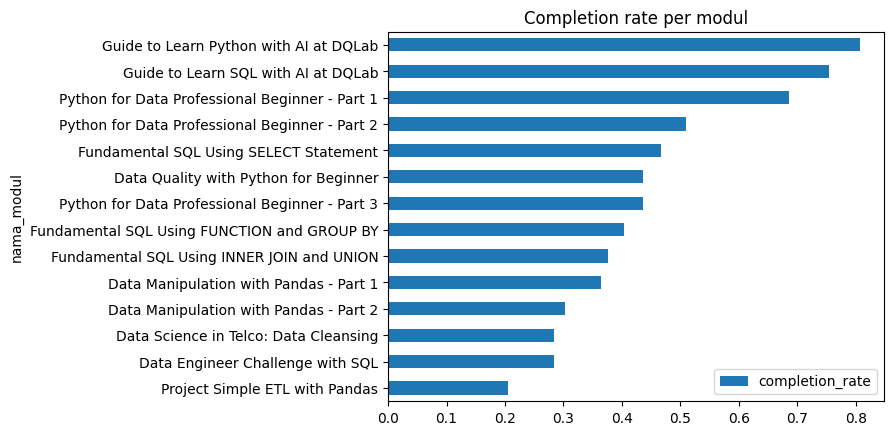

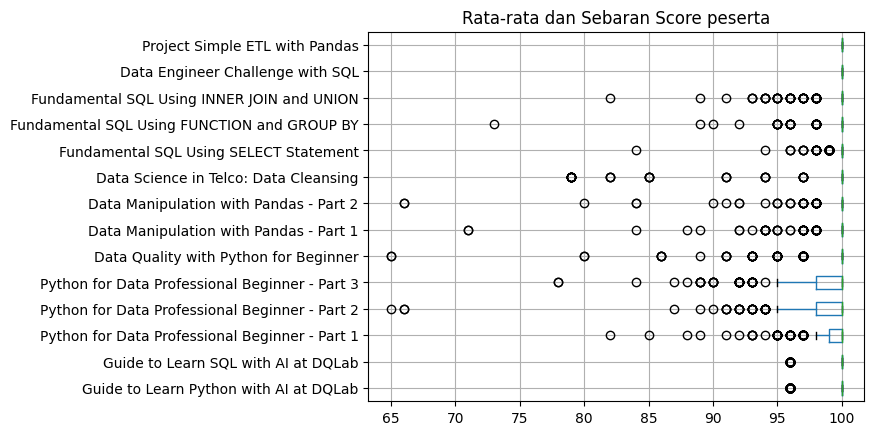

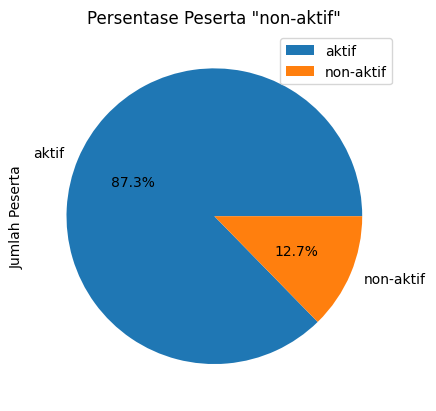

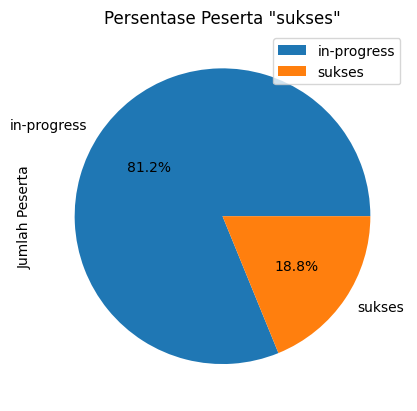

In [ ]:
# Final result -- overall pipeline

import pandas as pd
import re
import matplotlib.pyplot as plt


# Define Fungsi untuk convert url google sheet
# source: https://skills.ai/blog/import-google-sheets-to-pandas/
def convert_google_sheet_url(url):
    # Regular expression to match and capture the necessary part of the URL
    pattern = r'https://docs\.google\.com/spreadsheets/d/([a-zA-Z0-9-_]+)(/edit#gid=(\d+)|/edit.*)?'

    # Replace function to construct the new URL for TSV export
    # If gid is present in the URL, it includes it in the export URL, otherwise, it's omitted
    replacement = lambda m: f'https://docs.google.com/spreadsheets/d/{m.group(1)}/export?' + (f'gid={m.group(3)}&' if m.group(3) else '') + 'format=tsv'

    # Replace using regex
    new_url = re.sub(pattern, replacement, url)

    return new_url

# Minta input url dari user
input_gsheet_url = input('Masukkan URL Google Sheet (yang diperoleh dengan copy-paste langsung dari browser): ')
if not input_gsheet_url:
  # Jika user tidak input url, gunakan url berikut
  input_gsheet_url = 'https://docs.google.com/spreadsheets/d/1MdvIzVqQjNMFHgDi6sBqoqPqYm-LxLkZZjUUKfw_Qes/edit#gid=546294787'

# Ubah gsheet url agar berupa TSV
url = convert_google_sheet_url(input_gsheet_url)  # 'https://docs.google.com/spreadsheets/d/1MdvIzVqQjNMFHgDi6sBqoqPqYm-LxLkZZjUUKfw_Qes/export?format=tsv&gid=546294787'

# Load dataset Google Sheet
df = pd.read_csv(url, sep='\t')

# -------------------- #
# Transform 01 - Drop semua row dengan No Peserta = NA
df.dropna(subset=['No Peserta'], inplace=True)

# -------------------- #
# Transform 02 -
# Ambil index dari list nama kolom yang valuenya 'Unfinished Modul'
start_idx = df.columns.to_list().index('Unfinished Modul')

# Buat list baru sebagai master nama modul
mst_modul = df.columns.to_list()[start_idx + 1:]

# -------------------- #
# Transform 03 -
# Cast kolom menjadi tipe data string
df['Unfinished Modul'] = df['Unfinished Modul'].astype('str')

# Define Fungsi untuk cek nama modul dalam list
def func_cflag(unfinished, modul):
  if unfinished:
    return int(modul not in unfinished)  # mengembalikan nilai 1 jika modul telah diselesaikan
  else:
    return 0  # mengembalikan nilai 0 jika modul belum diselesaikan

# Generate kolom baru untuk flag modul selesai/belum
for modul in mst_modul:
  df[modul + '_cflag'] = df['Unfinished Modul'].apply(func_cflag, args=(modul,))

# -------------------- #
# Visualize 01 - Completion rate masing-masing modul
# Transform dataframe menjadi bentuk yang dapat dikonsumsi fungsi .plot.barh() pandas
# Ubah bentuk df menjadi 'long'/'stacked' dengan .melt()
df_melt = df.melt(id_vars=df.columns.to_list()[:start_idx + 1])  # ['name', 'No Peserta', 'total_score', 'Unfinished Modul']
# Ambil row terkait completion flag (_cflag) saja
df_test = df_melt[ df_melt['variable'].str.endswith('_cflag') ].copy()
# Perbaiki nama kolom agar sesuai nama modul
df_test['variable'] = df_test['variable'].str.replace('_cflag','')
# Rename kolom agar sesuai dengan konteks valuenya
df_test.rename(columns={'value': 'completion_rate', 'variable': 'nama_modul'}, inplace=True)
# Hitung rata-rata _cflag sebagai completion_rate, lalu urutkan dari yang
df_test = df_test.groupby('nama_modul')['completion_rate'].mean().reset_index()
df_test.sort_values('completion_rate', inplace=True)
# Generate bar plot
ax_01 = df_test.plot.barh(x='nama_modul', y='completion_rate', title='Completion rate per modul')
# Save hasil plot
fig = ax_01.get_figure()
fig.savefig('/chart-01-Completion Rate per Modul.png')

# -------------------- #
# Visualize 02 - Rata-rata dan Sebaran Score peserta untuk masing-masing modul
# Generate boxplot
plt.figure()
plt.title('Rata-rata dan Sebaran Score peserta')
ax_03 = df.boxplot(column=mst_modul, rot=0, vert=False)
# Save hasil plot
fig = ax_03.get_figure()
fig.savefig('/chart-02-Boxplot Score per Modul.png')

# -------------------- #
# Visualize 03 - Jumlah Peserta "non-aktif"
# Ubah bentuk df menjadi 'long'/'stacked' dengan .melt()
df_melt = df.melt(id_vars=df.columns.to_list()[:start_idx + 1])  # ['name', 'No Peserta', 'total_score', 'Unfinished Modul']
# Ambil row terkait completion flag (_cflag) saja
df_test = df_melt[ df_melt['variable'].str.endswith('_cflag') ].copy()
# Perbaiki nama kolom agar sesuai nama modul
df_test['variable'] = df_test['variable'].str.replace('_cflag','')
# Rename kolom agar sesuai dengan konteks valuenya
df_test.rename(columns={'value': 'completion_rate', 'variable': 'nama_modul'}, inplace=True)

# 03.1 Transformasi lanjutan untuk menghitung jumlah Peserta "non-aktif"
# Cek jumlah modul yang telah diselesaikan tiap peserta apakah kurang dari 1 (belum sama sekali)
df_test_1 = df_test.groupby('No Peserta')['completion_rate'].sum() < 1
df_test_1 = df_test_1.apply(lambda x: 'non-aktif' if x else 'aktif').reset_index()
# Hitung berapa Peserta yang "non-aktif" dan "aktif"
df_test_1 = df_test_1.groupby('completion_rate').count()
df_test_1 = df_test_1.rename(columns={'No Peserta': 'Jumlah Peserta'})
# Generate pie chart
plot = df_test_1.plot.pie(y='Jumlah Peserta', autopct="%.1f%%", title='Persentase Peserta "non-aktif"')
# Save hasil plot
fig = plot.get_figure()
fig.savefig('/chart-03.1-Persentase Peserta Non-aktif.png')


# 03.2 Transformasi lanjutan untuk menghitung jumlah Peserta "sukses"
# Cek jumlah modul yang telah diselesaikan tiap peserta apakah sama dengan total seluruh modul
df_test_2 = df_test.groupby('No Peserta')['completion_rate'].sum() == len(mst_modul)
df_test_2 = df_test_2.apply(lambda x: 'sukses' if x else 'in-progress').reset_index()
# Hitung berapa Peserta yang "non-aktif" dan "aktif"
df_test_2 = df_test_2.groupby('completion_rate').count()
df_test_2 = df_test_2.rename(columns={'No Peserta': 'Jumlah Peserta'})
# Generate pie chart
plot = df_test_2.plot.pie(y='Jumlah Peserta', autopct="%.1f%%", title='Persentase Peserta "sukses"')
# Save hasil plot
fig = plot.get_figure()
fig.savefig('/chart-03.2-Persentase Peserta Sukses.png')

# Load dataset Google Sheets

In [ ]:
import re

def convert_google_sheet_url(url):
    # Regular expression to match and capture the necessary part of the URL
    pattern = r'https://docs\.google\.com/spreadsheets/d/([a-zA-Z0-9-_]+)(/edit#gid=(\d+)|/edit.*)?'

    # Replace function to construct the new URL for TSV export
    # If gid is present in the URL, it includes it in the export URL, otherwise, it's omitted
    replacement = lambda m: f'https://docs.google.com/spreadsheets/d/{m.group(1)}/export?' + (f'gid={m.group(3)}&' if m.group(3) else '') + 'format=tsv'

    # Replace using regex
    new_url = re.sub(pattern, replacement, url)

    return new_url

input_gsheet_url = input('Masukkan URL Google Sheet (yang diperoleh dengan copy-paste langsung dari browser): ')
if not input_gsheet_url:
  # Jika user tidak input url, gunakan url berikut
  input_gsheet_url = 'https://docs.google.com/spreadsheets/d/1MdvIzVqQjNMFHgDi6sBqoqPqYm-LxLkZZjUUKfw_Qes/edit#gid=546294787'

print(convert_google_sheet_url(input_gsheet_url))

Masukkan URL Google Sheet (yang diperoleh dengan copy-paste langsung dari browser): 
https://docs.google.com/spreadsheets/d/1MdvIzVqQjNMFHgDi6sBqoqPqYm-LxLkZZjUUKfw_Qes/export?gid=546294787&format=tsv


In [ ]:
import pandas as pd
import re

def convert_google_sheet_url(url):
    # Regular expression to match and capture the necessary part of the URL
    pattern = r'https://docs\.google\.com/spreadsheets/d/([a-zA-Z0-9-_]+)(/edit#gid=(\d+)|/edit.*)?'

    # Replace function to construct the new URL for TSV export
    # If gid is present in the URL, it includes it in the export URL, otherwise, it's omitted
    replacement = lambda m: f'https://docs.google.com/spreadsheets/d/{m.group(1)}/export?' + (f'gid={m.group(3)}&' if m.group(3) else '') + 'format=tsv'

    # Replace using regex
    new_url = re.sub(pattern, replacement, url)

    return new_url

input_gsheet_url = input('Masukkan URL Google Sheet (yang diperoleh dengan copy-paste langsung dari browser): ')
if not input_gsheet_url:
  # Jika user tidak input url, gunakan url berikut
  input_gsheet_url = 'https://docs.google.com/spreadsheets/d/1MdvIzVqQjNMFHgDi6sBqoqPqYm-LxLkZZjUUKfw_Qes/edit#gid=546294787'

# Ubah gsheet url agar berupa TSV
url = convert_google_sheet_url(input_gsheet_url)  # 'https://docs.google.com/spreadsheets/d/1MdvIzVqQjNMFHgDi6sBqoqPqYm-LxLkZZjUUKfw_Qes/export?format=tsv&gid=546294787'

df = pd.read_csv(url, sep='\t')
df

Masukkan URL Google Sheet (yang diperoleh dengan copy-paste langsung dari browser): 


,name,No Peserta,total_score,Unfinished Modul,Guide to Learn Python with AI at DQLab,Guide to Learn SQL with AI at DQLab,Python for Data Professional Beginner - Part 1,Python for Data Professional Beginner - Part 2,Python for Data Professional Beginner - Part 3,Data Quality with Python for Beginner,Data Manipulation with Pandas - Part 1,Data Manipulation with Pandas - Part 2,Data Science in Telco: Data Cleansing,Fundamental SQL Using SELECT Statement,Fundamental SQL Using FUNCTION and GROUP BY,Fundamental SQL Using INNER JOIN and UNION,Data Engineer Challenge with SQL,Project Simple ETL with Pandas
0,Ade Nurhadi,1987291840-117,1400,NaN,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
1,Ahmad Syaifudin,1987291840-500,1400,NaN,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
2,Aidil Abdillah Suyudi,1987291840-315,1400,NaN,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
3,Alfi Khaerani,1987291840-575,1400,NaN,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
4,ALIFIA REVAN PRANANDA,1987291840-32,1400,NaN,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
853,Yoga Sadewa,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
854,Yola Achmad Zidanta,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
855,Yudha Siahaan,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
856,Yudhis Thiro Kabul Yunior,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Transform 01 - Drop row dengan No Peserta = NA

In [ ]:
import pandas as pd
import re

def convert_google_sheet_url(url):
    # Regular expression to match and capture the necessary part of the URL
    pattern = r'https://docs\.google\.com/spreadsheets/d/([a-zA-Z0-9-_]+)(/edit#gid=(\d+)|/edit.*)?'

    # Replace function to construct the new URL for TSV export
    # If gid is present in the URL, it includes it in the export URL, otherwise, it's omitted
    replacement = lambda m: f'https://docs.google.com/spreadsheets/d/{m.group(1)}/export?' + (f'gid={m.group(3)}&' if m.group(3) else '') + 'format=tsv'

    # Replace using regex
    new_url = re.sub(pattern, replacement, url)

    return new_url

input_gsheet_url = input('Masukkan URL Google Sheet (yang diperoleh dengan copy-paste langsung dari browser): ')
if not input_gsheet_url:
  # Jika user tidak input url, gunakan url berikut
  input_gsheet_url = 'https://docs.google.com/spreadsheets/d/1MdvIzVqQjNMFHgDi6sBqoqPqYm-LxLkZZjUUKfw_Qes/edit#gid=546294787'

# Ubah gsheet url agar berupa TSV
url = convert_google_sheet_url(input_gsheet_url)  # 'https://docs.google.com/spreadsheets/d/1MdvIzVqQjNMFHgDi6sBqoqPqYm-LxLkZZjUUKfw_Qes/export?format=tsv&gid=546294787'

# Load dataset Google Sheet
df = pd.read_csv(url, sep='\t')

# Transform 01 - Drop semua row dengan No Peserta = NA
df.dropna(subset=['No Peserta'], inplace=True)
df

Masukkan URL Google Sheet (yang diperoleh dengan copy-paste langsung dari browser): 


,name,No Peserta,total_score,Unfinished Modul,Guide to Learn Python with AI at DQLab,Guide to Learn SQL with AI at DQLab,Python for Data Professional Beginner - Part 1,Python for Data Professional Beginner - Part 2,Python for Data Professional Beginner - Part 3,Data Quality with Python for Beginner,Data Manipulation with Pandas - Part 1,Data Manipulation with Pandas - Part 2,Data Science in Telco: Data Cleansing,Fundamental SQL Using SELECT Statement,Fundamental SQL Using FUNCTION and GROUP BY,Fundamental SQL Using INNER JOIN and UNION,Data Engineer Challenge with SQL,Project Simple ETL with Pandas
0,Ade Nurhadi,1987291840-117,1400,NaN,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
1,Ahmad Syaifudin,1987291840-500,1400,NaN,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
2,Aidil Abdillah Suyudi,1987291840-315,1400,NaN,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
3,Alfi Khaerani,1987291840-575,1400,NaN,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
4,ALIFIA REVAN PRANANDA,1987291840-32,1400,NaN,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
843,Tri Adi,1987291840-198,0,"Guide to Learn Python with AI at DQLab,Guide t...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
844,Trisye Natalia Kilay,1987291840-432,0,"Guide to Learn Python with AI at DQLab,Guide t...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
845,Ujang .,1987291840-931,0,"Guide to Learn Python with AI at DQLab,Guide t...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
846,Umul muth,1987291840-998,0,"Guide to Learn Python with AI at DQLab,Guide t...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Transform 02 - buat List berisi nama seluruh modul
Asumsi: kolom dengan nama modul-modul selalu ditempatkan setelah kolom `Unfinished Modul`

In [ ]:
# Ambil index dari list nama kolom yang valuenya 'Unfinished Modul'
start_idx = df.columns.to_list().index('Unfinished Modul')

# Buat list baru sebagai master nama modul
mst_modul = df.columns.to_list()[start_idx + 1:]
print(mst_modul)

['Guide to Learn Python with AI at DQLab', 'Guide to Learn SQL with AI at DQLab', 'Python for Data Professional Beginner - Part 1', 'Python for Data Professional Beginner - Part 2', 'Python for Data Professional Beginner - Part 3', 'Data Quality with Python for Beginner', 'Data Manipulation with Pandas - Part 1', 'Data Manipulation with Pandas - Part 2', 'Data Science in Telco: Data Cleansing', 'Fundamental SQL Using SELECT Statement', 'Fundamental SQL Using FUNCTION and GROUP BY', 'Fundamental SQL Using INNER JOIN and UNION', 'Data Engineer Challenge with SQL', 'Project Simple ETL with Pandas']


# Transform 03 - buat kolom baru untuk flag modul 'Selesai' atau 'Unfinished'
Flag berupa angka 1 (Selesai) atau 0 (Unfinished).
Modul-modul yang unfinished dapat diketahui dari kolom `Unfinished Modul`. Modul yang tidak tercantum di kolom tersebut berarti Selesai.

In [ ]:
# Cast kolom menjadi tipe data string
df['Unfinished Modul'] = df['Unfinished Modul'].astype('str')

# Define Fungsi untuk cek nama modul dalam list
def func_cflag(unfinished, modul):
  if unfinished:
    return int(modul in unfinished)
  else:
    return 0

for modul in mst_modul:
  df[modul + '_cflag'] = df['Unfinished Modul'].apply(func_cflag, args=(modul,))

df.info()

['Guide to Learn Python with AI at DQLab',
 'Guide to Learn SQL with AI at DQLab',
 'Python for Data Professional Beginner - Part 1',
 'Python for Data Professional Beginner - Part 2',
 'Python for Data Professional Beginner - Part 3',
 'Data Quality with Python for Beginner',
 'Data Manipulation with Pandas - Part 1',
 'Data Manipulation with Pandas - Part 2',
 'Data Science in Telco: Data Cleansing',
 'Fundamental SQL Using SELECT Statement',
 'Fundamental SQL Using FUNCTION and GROUP BY',
 'Fundamental SQL Using INNER JOIN and UNION',
 'Data Engineer Challenge with SQL',
 'Project Simple ETL with Pandas']

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 749 entries, 0 to 848
Data columns (total 32 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   name                                                  692 non-null    object 
 1   No Peserta                                            749 non-null    object 
 2   total_score                                           749 non-null    int64  
 3   Unfinished Modul                                      749 non-null    object 
 4   Guide to Learn Python with AI at DQLab                605 non-null    float64
 5   Guide to Learn SQL with AI at DQLab                   565 non-null    float64
 6   Python for Data Professional Beginner - Part 1        514 non-null    float64
 7   Python for Data Professional Beginner - Part 2        382 non-null    float64
 8   Python for Data Professional Beginner - Part 3        326 no

# Visualize 01 - Completion rate masing-masing modul
Generate bar chart berisi completion rate atau `mean(<nama modul>_cflag)` tiap modul.

Chart ini dapat menjawab pertanyaan:

> Modul manakah yang paling banyak / sedikit diselesaikan oleh peserta ?



In [ ]:
# Visualize 01 - Completion rate masing-masing modul
# Transform dataframe menjadi bentuk yang dapat dikonsumsi fungsi .plot.barh() pandas

# Ubah bentuk df menjadi 'long'/'stacked' dengan .melt()
df_melt = df.melt(id_vars=df.columns.to_list()[:start_idx + 1])  # ['name', 'No Peserta', 'total_score', 'Unfinished Modul']
# Ambil row terkait completion flag (_cflag) saja
df_test = df_melt[ df_melt['variable'].str.endswith('_cflag') ].copy()
# Perbaiki nama kolom agar sesuai nama modul
df_test['variable'] = df_test['variable'].str.replace('_cflag','')
# Rename kolom agar sesuai dengan konteks valuenya
df_test.rename(columns={'value': 'completion_rate', 'variable': 'nama_modul'}, inplace=True)

In [ ]:
# Hitung rata-rata _cflag sebagai completion_rate, lalu urutkan dari yang
df_test = df_test.groupby('nama_modul')['completion_rate'].mean().reset_index()
df_test.sort_values('completion_rate', inplace=True)

df_test

,nama_modul,completion_rate
10,Project Simple ETL with Pandas,0.205607
0,Data Engineer Challenge with SQL,0.284379
4,Data Science in Telco: Data Cleansing,0.284379
2,Data Manipulation with Pandas - Part 2,0.303071
1,Data Manipulation with Pandas - Part 1,0.364486
6,Fundamental SQL Using INNER JOIN and UNION,0.376502
5,Fundamental SQL Using FUNCTION and GROUP BY,0.403204
13,Python for Data Professional Beginner - Part 3,0.435247
3,Data Quality with Python for Beginner,0.436582
7,Fundamental SQL Using SELECT Statement,0.467290


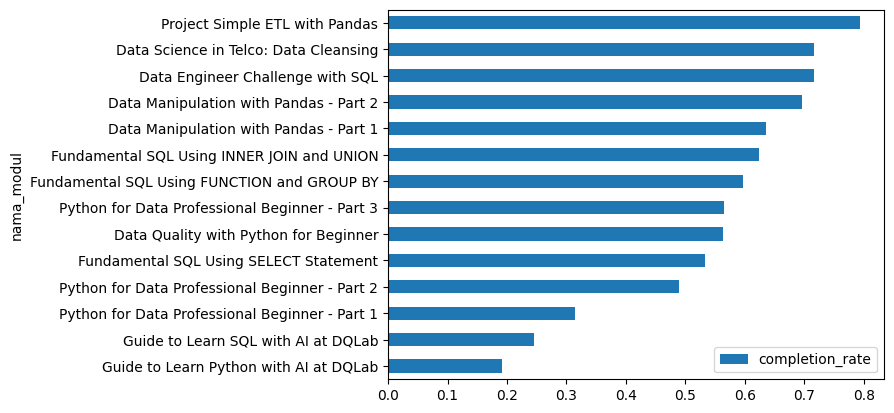

In [ ]:
import matplotlib.pyplot as plt

# Generate bar plot
ax = df_test.plot.barh(x='nama_modul', y='completion_rate')

# Visualize 02 - Rata-rata dan Sebaran Score peserta untuk masing-masing modul

Setiap modul memiliki range Score 0-100. Rata-rata perolehan Score cenderung tinggi (mendekati 100), tetapi beberapa modul mungkin cukup *challenging* sehingga peserta menggunakan Hint (tidak memperoleh skor maksimal). Hal ini menyebabkan boxplot sebaran Score pada modul yang *challenging* memiliki *whisker* yang lebih panjang.

Chart ini dapat menjawab pertanyaan:
> Modul manakah yang paling *challenging* ?

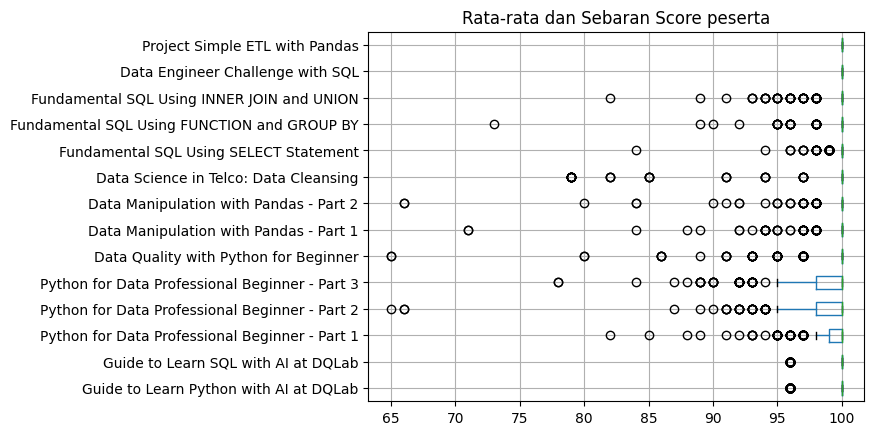

In [ ]:
# Visualize 02 - Rata-rata dan Sebaran Score peserta untuk masing-masing modul
# Generate boxplot
plt.figure()
plt.title('Rata-rata dan Sebaran Score peserta')
ax_03 = df.boxplot(column=mst_modul, rot=0, vert=False)

# Visualize 03 - Jumlah Peserta "non-aktif" dan Peserta "sukses"

Peserta "non-aktif" adalah peserta yang belum menyelesaikan modul sama sekali. Peserta "sukses" adalah peserta yang telah menyelesaikan seluruh modul.

> Berapa persen peserta "non-aktif" ? \
> Berapa persen peserta "sukses" ?

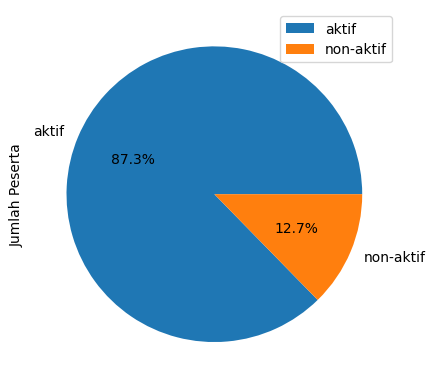

In [ ]:
# Visualize 03 - Jumlah Peserta "non-aktif"

# Ubah bentuk df menjadi 'long'/'stacked' dengan .melt()
df_melt = df.melt(id_vars=df.columns.to_list()[:start_idx + 1])  # ['name', 'No Peserta', 'total_score', 'Unfinished Modul']
# Ambil row terkait completion flag (_cflag) saja
df_test = df_melt[ df_melt['variable'].str.endswith('_cflag') ].copy()
# Perbaiki nama kolom agar sesuai nama modul
df_test['variable'] = df_test['variable'].str.replace('_cflag','')
# Rename kolom agar sesuai dengan konteks valuenya
df_test.rename(columns={'value': 'completion_rate', 'variable': 'nama_modul'}, inplace=True)

# 03.1 Transformasi lanjutan untuk menghitung jumlah Peserta "non-aktif"
# Cek jumlah modul yang telah diselesaikan tiap peserta apakah kurang dari 1 (belum sama sekali)
df_test_1 = df_test.groupby('No Peserta')['completion_rate'].sum() < 1
df_test_1 = df_test_1.apply(lambda x: 'non-aktif' if x else 'aktif').reset_index()
# Hitung berapa Peserta yang "non-aktif" dan "aktif"
df_test_1 = df_test_1.groupby('completion_rate').count()
df_test_1 = df_test_1.rename(columns={'No Peserta': 'Jumlah Peserta'})
# Generate pie chart
plot = df_test_1.plot.pie(y='Jumlah Peserta', autopct="%.1f%%")

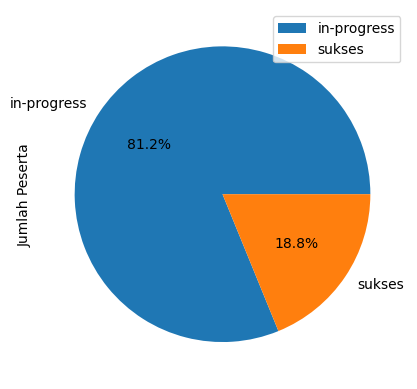

In [ ]:
# 03.2 Transformasi lanjutan untuk menghitung jumlah Peserta "sukses"
# Cek jumlah modul yang telah diselesaikan tiap peserta apakah sama dengan total seluruh modul
df_test_2 = df_test.groupby('No Peserta')['completion_rate'].sum() == len(mst_modul)
df_test_2 = df_test_2.apply(lambda x: 'sukses' if x else 'in-progress').reset_index()
# Hitung berapa Peserta yang "non-aktif" dan "aktif"
df_test_2 = df_test_2.groupby('completion_rate').count()
df_test_2 = df_test_2.rename(columns={'No Peserta': 'Jumlah Peserta'})
# Generate pie chart
plot = df_test_2.plot.pie(y='Jumlah Peserta', autopct="%.1f%%")